In [1]:
import numpy as np
import pandas as pd
import pickle
# SQL related packages
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
# sklearn packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression as Log
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
# text analysis packages
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
from nltk.stem.porter import PorterStemmer

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# access to sql database
dbname = 'patent_db'
username = 'jy'
pswd = 'jy'

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# reading from sql database
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

#### Extract claims

In [26]:
# read data from 2004-2007
years = np.arange(2004, 2008)

# dataframe to store the results
claims = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT claims, id, payment_times
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    claims = pd.concat([claims, results], axis = 0)
    
# check size of the data
claims.shape

(12033, 3)

In [27]:
# extract the response variable
# reformat the response variable into binary
y_data = np.zeros(abstracts.shape[0])
y_data[abstracts['payment_times'].values >= 2] = 1

print "Percentage of patents with > 1 maintenance fee payments: ", np.mean(y_data)

Percentage of patents with > 1 maintenance fee payments:  0.628521565694


#### Tokenization and cleaning

In [6]:
def tokenize_cleaning(text):
    # tokenize the text first
    tokens = word_tokenize(text.decode('utf-8'))
    
    # lowercase all the words
    tokens = [w.lower() for w in tokens]
    
    # clean up stop words and punctuations 
    stop_list = stopwords.words('english') + list(string.punctuation)

    tokens_no_stop = [token for token in tokens
                        if token not in stop_list]
    
    # extract stem of the words
    stemmer = PorterStemmer()
    tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]
    
    return tokens_no_stop

In [28]:
# tokenize_clean the abstracts and count the occurence of the words

cleaned_text = []
for i in range(claims.shape[0]):
    tokens = tokenize_cleaning(claims['claims'].iloc[i])
    cleaned_text.append(' '.join(word for word in tokens))

In [29]:
# convert to bag-of-words
# min number selected by examine the 'number' words
vectorizer = CountVectorizer(max_df = 0.4, min_df=140)

# performe a count-based vectorization of the document
word_vec = vectorizer.fit(cleaned_text)
word_counts = word_vec.transform(cleaned_text)

word_counts = word_counts.toarray()

In [30]:
word_counts.shape

(12033, 769)

(array([ 708.,   42.,   12.,    2.,    1.,    0.,    2.,    0.,    1.,    1.]),
 array([   224. ,   4552.1,   8880.2,  13208.3,  17536.4,  21864.5,
         26192.6,  30520.7,  34848.8,  39176.9,  43505. ]),
 <a list of 10 Patch objects>)

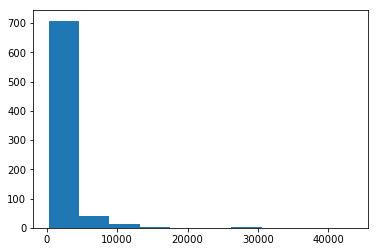

In [31]:
# check the distribution of word occurance
total_counts = np.sum(word_counts, axis = 0)
plt.hist(np.transpose(total_counts))

In [32]:
df = pd.DataFrame({
    'word': word_vec.get_feature_names(),
    'count': total_counts
})

In [33]:
df.iloc[:50]

,count,word
0,2022,10
1,712,100
2,1015,11
3,952,12
4,748,13
5,723,14
6,920,15
7,644,16
8,526,17
9,650,18


In [115]:
tf_vectorizer = TfidfVectorizer()
tfidf_article = tf_vectorizer.fit_transform(cleaned_text)
tfidf_article = tfidf_article.toarray()

print tfidf_article.shape

(12033, 29829)


#### Spliting train-test data and subsampling

In [34]:
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(word_counts, y_data, 
                                                    test_size = 0.2, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (9626, 769)
x_test:  (2407, 769)
y_train:  (9626,)
y_test:  (2407,)


In [35]:
### subsampling the training data
# sample the same number of'useful' patents as the 'not useful' patents
# size of each class
num_size = np.sum(y_train == 0)

#random shuffle the rows
n = x_train.shape[0]
perm = range(n)
np.random.shuffle(perm)

x_train = x_train[perm]
y_train = y_train[perm]

# separate the two classes
x_useful = x_train[y_train == 1, :]
x_not_useful = x_train[y_train == 0, :]
y_useful = y_train[y_train == 1]
y_not_useful = y_train[y_train == 0]

# sample num_size from the 'useful' class
x_useful = x_useful[:num_size]
y_useful = y_useful[:num_size]

# combine the two classes
x_train_sub = np.concatenate((x_useful, x_not_useful), axis = 0)
y_train_sub = np.concatenate((y_useful, y_not_useful), axis = 0)

# shuffle again
# shuffle the combined data
n2 = x_train_sub.shape[0]
perm2 = range(n2)
np.random.shuffle(perm2)

x_train_sub = x_train_sub[perm2]
y_train_sub = y_train_sub[perm2]

# check the size
print x_train_sub.shape
print y_train_sub.shape

(7136, 769)
(7136,)


In [36]:
# try Naive Bayes with Gaussian Distribution
gnb = GaussianNB()

# fit on the training data
gnb.fit(x_train_sub, y_train_sub)

GaussianNB(priors=None)

In [37]:
# predict on the test data
y_pred = gnb.predict(x_test)

In [38]:
# accuracy
np.mean(y_pred == y_test)

0.45201495637723305

In [39]:
metrics.confusion_matrix(y_test, y_pred)

array([[ 752,  150],
       [1169,  336]])

### PCA

In [123]:
# try dimensionality reduction using PCA
pca = PCA()

x_train_pca = pca.fit_transform(x_train_sub)
x_test_pca = pca.transform(x_test)

In [124]:
# find the cum-variance explained at each level
total_var = np.cumsum(pca.explained_variance_ratio_)
n_pc = np.where((total_var > 0.9) == True)[0][0]

In [125]:
n_pc

3700

In [40]:
### use logistic regression

# call the model function
model = Log()
# parameter tuning
c =  np.logspace(-5, 5, 11)

# use grid search with 5-fold CV
grid_model = GridSearchCV(model, param_grid = {'C': c}, cv  = 5, scoring = 'accuracy')
# fit on the data
grid_model = grid_model.fit(x_train_sub, y_train_sub) 

In [42]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: 0.553391255605
Best parameter:  {'C': 0.0001}


In [43]:
# check confusion matrix
best_log = grid_model.best_estimator_
best_log.fit(x_train_sub, y_train_sub)
y_pred = best_log.predict(x_test)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_pred, y_test)
print "Precision: ", metrics.precision_score(y_pred, y_test)
print "Recall: ", metrics.recall_score(y_pred, y_test)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.552139592854
F1 score:  0.611111111111
Precision:  0.562790697674
Recall:  0.668508287293


array([[482, 420],
       [658, 847]])

In [44]:
### tune random forest

model = RandomForestClassifier(n_estimators = 100)

# tune max_features
param_space = np.arange(2, 15, 2)

grid_model = GridSearchCV(model, n_jobs = 4, 
                          param_grid = {'max_features': param_space}, 
                          cv  = 5, scoring = 'accuracy')
# fit on the data
# grid_model = grid_model.fit(x_train_pca[:, :n_pc], y_train_sub)
grid_model = grid_model.fit(x_train_sub, y_train_sub)

In [45]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: 0.560397982063
Best parameter:  {'max_features': 6}


In [46]:
# check confusion matrix
best_rf = grid_model.best_estimator_
best_rf.fit(x_train_sub, y_train_sub)
y_pred = best_rf.predict(x_test)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_test, y_pred)
print "Precision: ", metrics.precision_score(y_test, y_pred)
print "Recall: ", metrics.recall_score(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.570004154549
F1 score:  0.62969588551
Precision:  0.682170542636
Recall:  0.584717607973


array([[492, 410],
       [625, 880]])